In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
import tensorflow.contrib.metrics as metrics
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SVMSMOTE
from imblearn.under_sampling import NearMiss
from scipy.stats import norm

tf.set_random_seed(1)
np.random.seed(1)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Using TensorFlow backend.


In [2]:
#Just for drawing the confusion matrix.
import itertools
def plot_confusion_matrix(cm, classes=[0,1],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Data & Sampling & EDA

In [3]:
df = pd.read_csv('creditcard.csv')
df = df.sample(frac=1).reset_index(drop=True)

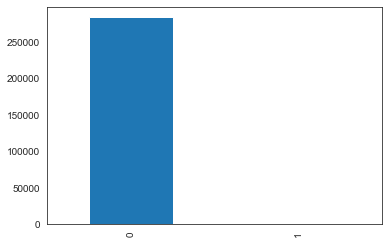

0    284315
1       492
Name: Class, dtype: int64
0    0.998273
1    0.001727
Name: Class, dtype: float64


In [4]:
with sns.axes_style("white"):
    df.Class.value_counts().plot(kind='bar')
    plt.show()
print(df['Class'].value_counts())
print(df['Class'].value_counts()/len(df['Class']))

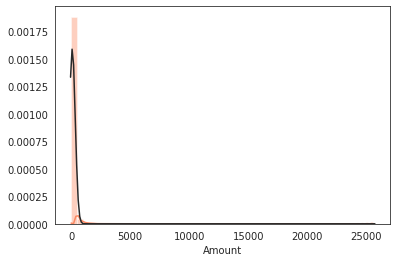

25691.16 0.0


In [5]:
with sns.axes_style("white"):
    sns.distplot(df.Amount, fit=norm, color='#FB8861')
plt.show()
print(np.max(df.Amount.values), np.min(df.Amount.values))

In [6]:
df.Amount = df.Amount**(1/6)

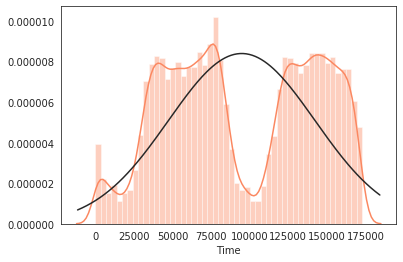

In [7]:
with sns.axes_style("white"):
    sns.distplot(df.Time, fit=norm, color='#FB8861')
plt.show() #drop out
# It seems like mixture of 2 ot more continuous distributions.

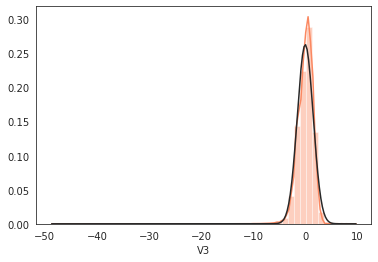

In [8]:
with sns.axes_style("white"):
    sns.distplot(df.V3, fit=norm, color='#FB8861')
plt.show()

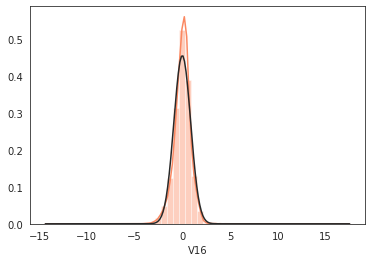

In [9]:
with sns.axes_style("white"):
    sns.distplot(df.V16, fit=norm, color='#FB8861')
plt.show()

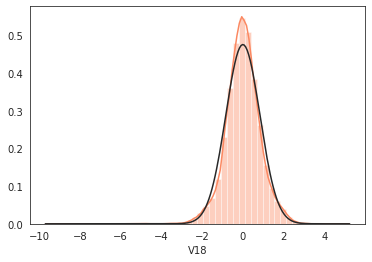

In [10]:
with sns.axes_style("white"):
    sns.distplot(df.V18, fit=norm, color='#FB8861')
plt.show()

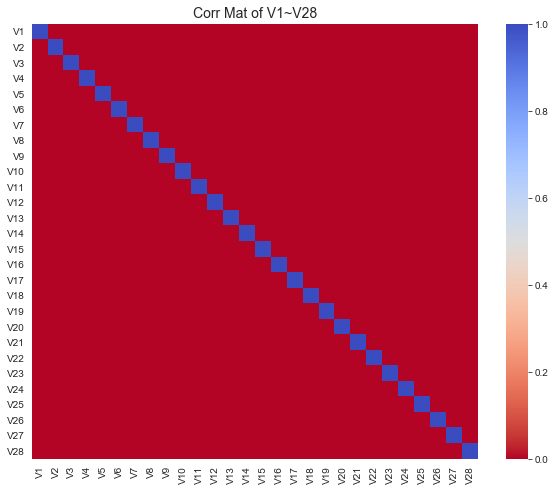

In [11]:
v = df.drop(['Time','Class','Amount'], axis=1)
with sns.axes_style("white"):
    plt.figure(figsize=(10,8))
    v_corr_2 = v.corr()
    sns.heatmap(v_corr_2, cmap='coolwarm_r')
    plt.title('Corr Mat of V1~V28', fontsize=14)
    plt.show()

In [12]:
#Original Data => Original test & Original Train using Striatified for saving data structure
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold, StratifiedKFold

x = df.drop(['Class','Time'], axis=1)
y = df['Class']

skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in skf.split(x, y):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

x_train = tf.keras.utils.normalize(x_train.values, axis = 1, order = 1) 
x_test = tf.keras.utils.normalize(x_test.values, axis = 1, order = 1) 
y_train = y_train.values
y_test = y_test.values

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
np.sum(y_train)

(227846, 29) (227846, 1) (56961, 29) (56961, 1)


394

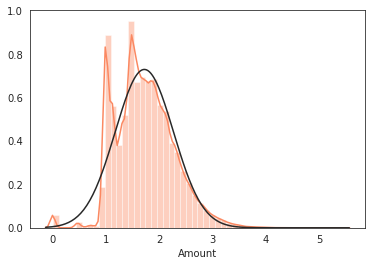

In [13]:
with sns.axes_style("white"):
    sns.distplot(df.Amount, fit=norm, color='#FB8861')
plt.show()

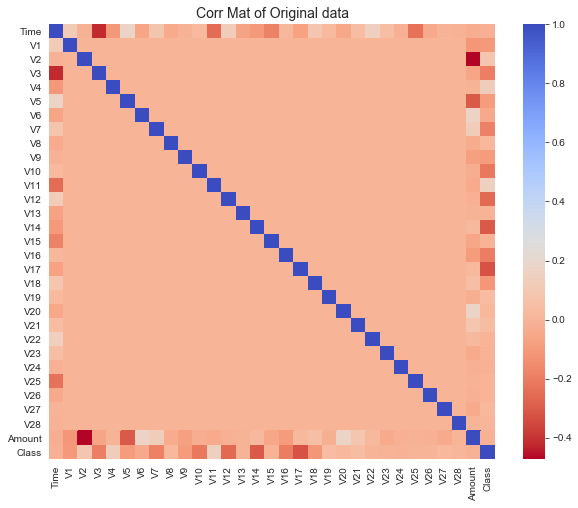

In [14]:
with sns.axes_style("white"):
    plt.figure(figsize=(10,8))
    sub_sample_corr_2 = df.corr()
    sns.heatmap(sub_sample_corr_2, cmap='coolwarm_r')
    plt.title('Corr Mat of Original data', fontsize=14)
    plt.show()

In [15]:
## UnderSampling
nm = NearMiss(sampling_strategy='majority')
x_train_u, y_train_u = nm.fit_sample(x_train, y_train)
x_train_u.shape, y_train_u.shape

((788, 29), (788,))

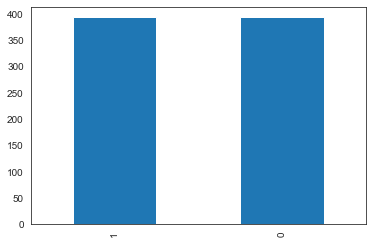

1    394
0    394
Name: Class, dtype: int64
1    0.5
0    0.5
Name: Class, dtype: float64


In [16]:
col = df.columns
df1 = pd.DataFrame(x_train_u.reshape(788,29), columns=col[:29])
df2 = pd.DataFrame(y_train_u.reshape(788,1), columns=col[30:])
df_u = pd.concat([df1,df2], axis=1)
with sns.axes_style("white"):
    df_u.Class.value_counts().plot(kind='bar')
    plt.show()
print(df_u['Class'].value_counts())
print(df_u['Class'].value_counts()/len(df_u['Class']))

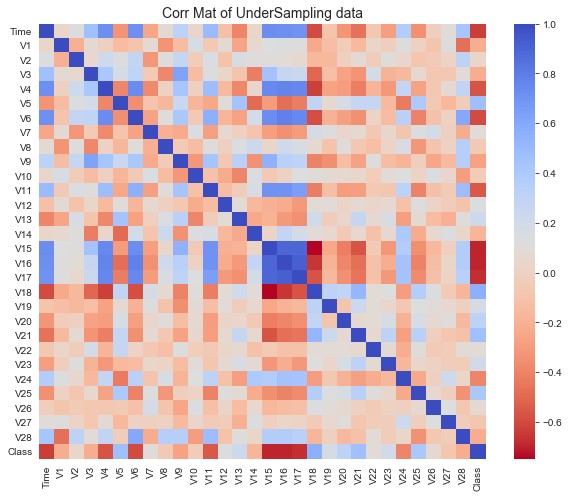

In [17]:
with sns.axes_style("white"):
    plt.figure(figsize=(10,8))
    sub_sample_corr_2 = df_u.corr()
    sns.heatmap(sub_sample_corr_2, cmap='coolwarm_r')
    plt.title('Corr Mat of UnderSampling data', fontsize=14)
    plt.show()

In [18]:
## OverSampling
ss = SVMSMOTE(sampling_strategy='minority')
x_train_o, y_train_o = ss.fit_sample(x_train, y_train)
x_train_o.shape, y_train_o.shape

((454904, 29), (454904,))

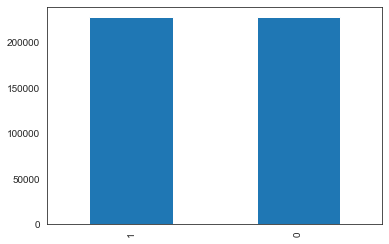

1    227452
0    227452
Name: Class, dtype: int64
1    0.5
0    0.5
Name: Class, dtype: float64


In [19]:
df1 = pd.DataFrame(x_train_o.reshape(454904,29), columns=col[:29])
df2 = pd.DataFrame(y_train_o.reshape(454904,1), columns=col[30:])
df_o = pd.concat([df1,df2], axis=1)
with sns.axes_style("white"):
    df_o.Class.value_counts().plot(kind='bar')
    plt.show()
print(df_o['Class'].value_counts())
print(df_o['Class'].value_counts()/len(df_o['Class']))

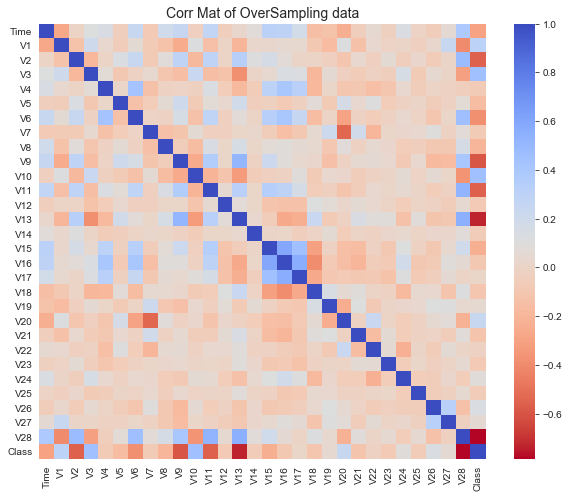

In [20]:
with sns.axes_style("white"):
    plt.figure(figsize=(10,8))
    sub_sample_corr_2 = df_o.corr()
    sns.heatmap(sub_sample_corr_2, cmap='coolwarm_r')
    plt.title('Corr Mat of OverSampling data', fontsize=14)
    plt.show()

Model

In [21]:
# NN model
from sklearn.metrics import mean_squared_error

epochs = 2000
lr = 1e-3
hidden_layers1 = 30
hidden_layers2 = 15

#model
X = tf.placeholder(tf.float32, (None,29), name="X")
Y = tf.placeholder(tf.float32, (None,1), name="Y")
is_training = tf.Variable(True, dtype=tf.bool)
initializer = tf.variance_scaling_initializer(seed=None)
cost_history = np.empty(shape=[1],dtype=float)

h0 = tf.layers.dense(X,hidden_layers1, kernel_initializer = initializer, 
                     use_bias=True, bias_initializer = tf.ones_initializer())
b0 = tf.layers.batch_normalization(h0, 1, momentum=0.9)
b0_act = tf.nn.leaky_relu(b0)

dropout0 = tf.layers.dropout(h0, rate=0.5)
h1 = tf.layers.dense(dropout0, hidden_layers2 ,kernel_initializer=initializer, 
                     use_bias=True, bias_initializer = tf.ones_initializer())
b1 = tf.layers.batch_normalization(h1, 1, momentum=0.9)
b1_act = tf.nn.leaky_relu(b1)
dropout1 = tf.layers.dropout(h1, rate=0.5)

h2 = tf.layers.dense(dropout1, 1, activation=None)
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=h2) #try weight
cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(cost)
#optimizer=tf.train.ProximalGradientDescentOptimizer(learning_rate=lr).minimize(cost)
#optimizer=tf.train.RMSPropOptimizer(learning_rate=lr).minimize(cost)
predicted = tf.nn.sigmoid(h2)
correct_pred = tf.equal(tf.round(predicted),Y)
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32))

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [22]:
# fit LC for the original set
from sklearn.model_selection import GridSearchCV

log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)#GridSearchCV(model, parameter_grid)
grid_log_reg.fit(x_train, y_train)
 
log_reg = grid_log_reg.best_estimator_ #best C(Normalize Factor): 0.01
log_reg.fit(x_train, y_train)
y_pred = log_reg.predict(x_test)

0.23469387755102042
0.0002989641770571373
[[56846    17]
 [   23    75]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.82      0.77      0.79        98

    accuracy                           1.00     56961
   macro avg       0.91      0.88      0.89     56961
weighted avg       1.00      1.00      1.00     56961

0.9992977651375503
0.8152173913043478
0.7653061224489796
0.7894736842105263
0.8628518352642217


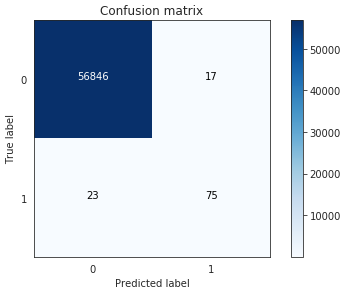

In [23]:
# Results of LC for the original data set
print(confusion_matrix(y_test, y_pred)[1,0]/np.sum(y_test==1))
print(confusion_matrix(y_test, y_pred)[0,1]/np.sum(y_test==0))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

y_score = cross_val_predict(log_reg, x_train, y_train, cv=5)
#def plot_roc_curve(fpr, tpr, model=None):
#    plt.plot(fpr, tpr, linewidth=2)
#    plt.plot([0,1],[0,1], 'k--')
#    plt.xlabel('o1o')
#    plt.ylabel('x1x')
#plot_roc_curve(fpr, tpr)
#plt.show()
fpr, tpr, thresholds = roc_curve(y_train, y_score)
print(roc_auc_score(y_train, y_score))

with sns.axes_style("white"):
    plot_confusion_matrix(confusion_matrix(y_test, y_pred))
plt.show()

Step:     0	Loss: 1.042	Acc: 0.17%
Step:   500	Loss: 0.006	Acc: 99.83%
Step:  1000	Loss: 0.003	Acc: 99.93%
Step:  1500	Loss: 0.003	Acc: 99.93%
Step:  2000	Loss: 0.003	Acc: 99.93%


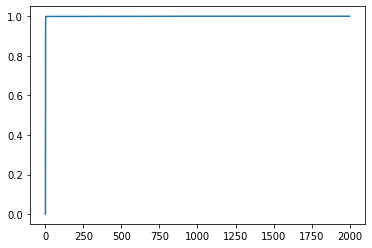

In [24]:
# fit NN for the original set
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(epochs+1):
        sess.run(optimizer,feed_dict={X: x_train,Y: y_train})
        loss, _, acc = sess.run([cost,optimizer,accuracy],feed_dict={X: x_train, Y: y_train})
        cost_history = np.append(cost_history,acc)
        if step % 500 == 0:
            print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(step,loss,acc))
    y_pred = sess.run(tf.cast(tf.round(predicted),tf.int32),feed_dict={X:x_test})
    
#Learing Curve
plt.plot(cost_history[1:])
plt.show()
    

0.22448979591836735
0.0002989641770571373
[[56846    17]
 [   22    76]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.82      0.78      0.80        98

    accuracy                           1.00     56961
   macro avg       0.91      0.89      0.90     56961
weighted avg       1.00      1.00      1.00     56961

0.9993153210091115
0.8172043010752689
0.7755102040816326
0.7958115183246073
0.8876056199522878


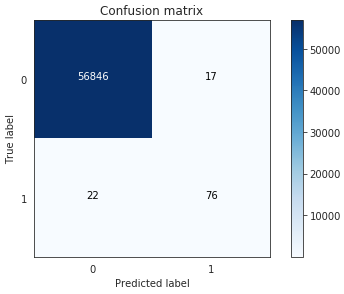

In [25]:
# Results of NN for the original data set
print(confusion_matrix(y_test, y_pred)[1,0]/np.sum(y_test==1))
print(confusion_matrix(y_test, y_pred)[0,1]/np.sum(y_test==0))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))
with sns.axes_style("white"):
    plot_confusion_matrix(confusion_matrix(y_test, y_pred))
plt.show()

In [26]:
# fit LC for the undersampled set
from sklearn.model_selection import GridSearchCV

log_reg_params = {"penalty": ['l1', 'l2'], 'C': [1e-3, 0.01, 0.1, 1, 10, 100, 1e+3]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)#GridSearchCV(model, parameter_grid)
grid_log_reg.fit(x_train_u, y_train_u)

log_reg = grid_log_reg.best_estimator_ #best C(Normalize Factor): 1
log_reg.fit(x_train_u, y_train_u)
y_pred = log_reg.predict(x_test)

0.16326530612244897
0.591104936426147
[[23251 33612]
 [   16    82]]
              precision    recall  f1-score   support

           0       1.00      0.41      0.58     56863
           1       0.00      0.84      0.00        98

    accuracy                           0.41     56961
   macro avg       0.50      0.62      0.29     56961
weighted avg       1.00      0.41      0.58     56961

0.4096311511384983
0.002433667715320235
0.8367346938775511
0.004853219696969696
0.8781725888324873


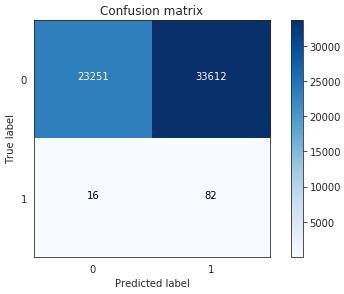

In [27]:
# Results of LC for the undersampled data set    
print(confusion_matrix(y_test, y_pred)[1,0]/np.sum(y_test==1))
print(confusion_matrix(y_test, y_pred)[0,1]/np.sum(y_test==0))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

y_score = cross_val_predict(log_reg, x_train_u, y_train_u, cv=5)
#def plot_roc_curve(fpr, tpr, model=None):
#    plt.plot(fpr, tpr, linewidth=2)
#    plt.plot([0,1],[0,1], 'k--')
#    plt.xlabel('o1o')
#    plt.ylabel('x1x')
#plot_roc_curve(fpr, tpr)
#plt.show()
fpr, tpr, thresholds = roc_curve(y_train_u, y_score)
print(roc_auc_score(y_train_u, y_score))
with sns.axes_style("white"):
    plot_confusion_matrix(confusion_matrix(y_test, y_pred))
plt.show()

Step:     0	Loss: 0.716	Acc: 50.00%
Step:   500	Loss: 0.273	Acc: 88.58%
Step:  1000	Loss: 0.264	Acc: 89.34%
Step:  1500	Loss: 0.263	Acc: 89.21%
Step:  2000	Loss: 0.263	Acc: 89.21%


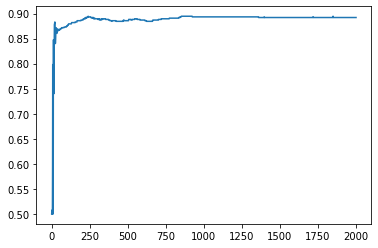

In [28]:
# fit NN for the undersampled set
y_train_u = y_train_u.reshape(-1,1) # matching the shape

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(epochs+1):
        sess.run(optimizer,feed_dict={X: x_train_u,Y: y_train_u})
        loss, _,acc=sess.run([cost,optimizer,accuracy],feed_dict={X: x_train_u, Y: y_train_u})
        cost_history=np.append(cost_history,acc)
        if step % 500 == 0:
            print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(step,loss,acc))
    y_pred = sess.run(tf.cast(tf.round(predicted),tf.int32),feed_dict={X:x_test})

#Learing Curve
plt.plot(cost_history[2002:])
plt.show()

0.1326530612244898
0.4582065666602184
[[30808 26055]
 [   13    85]]
              precision    recall  f1-score   support

           0       1.00      0.54      0.70     56863
           1       0.00      0.87      0.01        98

    accuracy                           0.54     56961
   macro avg       0.50      0.70      0.35     56961
weighted avg       1.00      0.54      0.70     56961

0.5423535401415003
0.0032517214996174446
0.8673469387755102
0.006479152374418782
0.7045701860576459


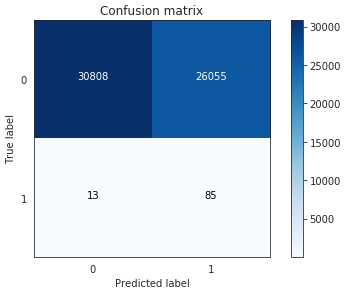

In [29]:
# Results of NN for the undersampled data set    
print(confusion_matrix(y_test, y_pred)[1,0]/np.sum(y_test==1))
print(confusion_matrix(y_test, y_pred)[0,1]/np.sum(y_test==0))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))
with sns.axes_style("white"):
    plot_confusion_matrix(confusion_matrix(y_test, y_pred))
plt.show()

In [30]:
# fit LC for the oversampled set
from sklearn.model_selection import GridSearchCV

log_reg_params = {"penalty": ['l1', 'l2'], 'C': [1e-3, 0.01, 0.1, 1, 10, 100, 1e+3]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)#GridSearchCV(model, parameter_grid)
grid_log_reg.fit(x_train_o, y_train_o)

log_reg = grid_log_reg.best_estimator_ #best C(Normalize Factor): 1
log_reg.fit(x_train_o, y_train_o)
y_pred = log_reg.predict(x_test)

0.11224489795918367
0.0077027240912368325
[[56425   438]
 [   11    87]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56863
           1       0.17      0.89      0.28        98

    accuracy                           0.99     56961
   macro avg       0.58      0.94      0.64     56961
weighted avg       1.00      0.99      0.99     56961

0.9921174136690016
0.1657142857142857
0.8877551020408163
0.27929373996789725
0.9942229569315724


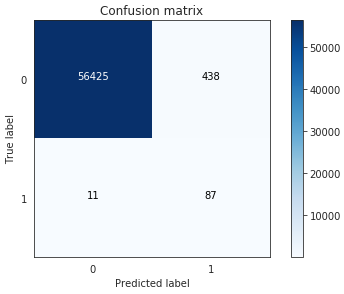

In [31]:
# Results of LC for the oversampled data set    
print(confusion_matrix(y_test, y_pred)[1,0]/np.sum(y_test==1))
print(confusion_matrix(y_test, y_pred)[0,1]/np.sum(y_test==0))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

y_score = cross_val_predict(log_reg, x_train_o, y_train_o, cv=5)
#def plot_roc_curve(fpr, tpr, model=None):
#    plt.plot(fpr, tpr, linewidth=2)
#    plt.plot([0,1],[0,1], 'k--')
#    plt.xlabel('o1o')
#    plt.ylabel('x1x')
#plot_roc_curve(fpr, tpr)
#plt.show()
fpr, tpr, thresholds = roc_curve(y_train_o, y_score)
print(roc_auc_score(y_train_o, y_score))
with sns.axes_style("white"):
    plot_confusion_matrix(confusion_matrix(y_test, y_pred))
plt.show()

Step:     0	Loss: 0.758	Acc: 50.00%
Step:   500	Loss: 0.028	Acc: 99.09%
Step:  1000	Loss: 0.019	Acc: 99.32%
Step:  1500	Loss: 0.017	Acc: 99.43%
Step:  2000	Loss: 0.017	Acc: 99.45%


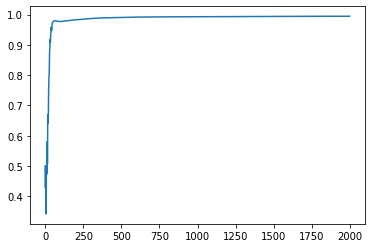

In [32]:
# fit NN for the oversampled set
y_train_o = y_train_o.reshape(-1,1)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(epochs+1):
        sess.run(optimizer,feed_dict={X: x_train_o,Y: y_train_o})
        loss, _,acc=sess.run([cost,optimizer,accuracy],feed_dict={X: x_train_o, Y: y_train_o})
        cost_history=np.append(cost_history,acc)
        if step % 500 == 0:
            print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(step,loss,acc))
    y_pred = sess.run(tf.cast(tf.round(predicted),tf.int32),feed_dict={X:x_test})
    
#Learing Curve
plt.plot(cost_history[4004:])
plt.show()

0.11224489795918367
0.007720310219299017
[[56424   439]
 [   11    87]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56863
           1       0.17      0.89      0.28        98

    accuracy                           0.99     56961
   macro avg       0.58      0.94      0.64     56961
weighted avg       1.00      0.99      0.99     56961

0.9920998577974404
0.16539923954372623
0.8877551020408163
0.27884615384615385
0.9400173959107586


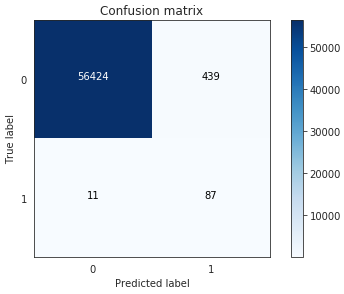

In [33]:
# Results of NN for the oversampled data set    
print(confusion_matrix(y_test, y_pred)[1,0]/np.sum(y_test==1))
print(confusion_matrix(y_test, y_pred)[0,1]/np.sum(y_test==0))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))
with sns.axes_style("white"):
    plot_confusion_matrix(confusion_matrix(y_test, y_pred))
plt.show()